## Take-home assignment (Apple Bluetooth QA Team Interview)
#### Submitted by: 06/03/2018 Aditya Shirode (avshirod@ncsu.edu)

##### Description of Assignment
Presume, you are already working with an App Developer who recently built an app that collects statistics from customers when they visit a certain Restaurant  
You are given a backend database (data.csv) that gets generated from the above step  

- Based on the above information, you are expected to aggregate the data and come up with UI Views that shall help App Developers understand **user patterns** to further *optimize the App*  
- Please reference the provided Database, sort and combine one or more data points and come up with **Top trends** (in the form of Graphical Views) for the same 
- Please provide a ‘Summary’ of the findings at the end that portrays the customer experience

#### Reading the Data

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt, ceil

%matplotlib inline

# sns.set(rc={'figure.figsize':(15, 10)})
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["xtick.labelsize"], plt.rcParams["ytick.labelsize"] = 10, 10

Let's read the data using *pandas* and take a peek at what's inside

In [2]:
# Read the data
data = pd.read_csv('data.csv')

In [3]:
# Take a peek at what's inside
data.head()

,Sr. No.,Restaurant Name,Cuisine,Average Cost per meal,Distance from home,Serves Alcohol,Wait time,Close for,Special Deals
0,46,A,American,$5.00,10 miles,Yes,1h,Lunch,No
1,20,A,American,$10.00,10 miles,Yes,5m,Dinner,Yes
2,39,A,Chinese,$5.00,10 miles,Yes,1h,Dinner,Yes
3,9,A,Chinese,$20.00,10 miles,Yes,5m,Dinner,Yes
4,25,A,Greek,$5.00,10 miles,No,5m,Breakfast,Yes


In [4]:
# Observe data types
data.dtypes

Sr. No.                   int64
Restaurant Name          object
Cuisine                  object
Average Cost per meal    object
Distance from home       object
Serves Alcohol           object
Wait time                object
Close for                object
Special Deals            object
dtype: object

As we can see, all the data is read as objects at the moment  
By looking at the head of the dataframe, we realize that their are various types at hand:  
- Categorical (Restaurant name, Cuisine, Close for)
- Boolean (Serves alcohol, Special deals)
- Numeric (Average cost per meal, Distance from home, Wait time)

Let's convert them into proper format so that it will reduce our work later  

We'll remove the currency formatting from 'Average Cost' and store it as a float  
Let's also convert the wait time to a uniform unit of minutes across all records

In [5]:
# Convert the columns into proper format so that they will be easy to transform and plot
data['Restaurant Name'] = data['Restaurant Name'].astype('category')
data['Cuisine'] = data['Cuisine'].astype('category')
data['Average Cost per meal (USD)'] = data['Average Cost per meal'].replace('[\$,]', '', regex=True).astype(float)
data['Distance from home (miles)'] = data['Distance from home'].replace(' miles', '', regex=True).astype(int)
data['Serves Alcohol'] = data['Serves Alcohol'].map({"Yes": True, "No": False})
data['Wait Time (minutes)'] = data['Wait time'].apply(lambda x: pd.Timedelta(x).total_seconds() / 60.0)
data['Close for'] = data['Close for '].astype('category')
data['Special Deals'] = data['Special Deals'].map({"Yes": True, "No": False})

In [6]:
# Drop original columns in favor of formatted columns
df = data.drop(columns=['Average Cost per meal', 'Distance from home', 'Wait time', 'Close for '])
df = df.set_index('Sr. No.')

In [7]:
# Take a look at this transformed data
df.head()

,Restaurant Name,Cuisine,Serves Alcohol,Special Deals,Average Cost per meal (USD),Distance from home (miles),Wait Time (minutes),Close for
Sr. No.,,,,,,,,
46,A,American,True,False,5.0,10,60.0,Lunch
20,A,American,True,True,10.0,10,5.0,Dinner
39,A,Chinese,True,True,5.0,10,60.0,Dinner
9,A,Chinese,True,True,20.0,10,5.0,Dinner
25,A,Greek,False,True,5.0,10,5.0,Breakfast


In [8]:
# The data types are better now
df.dtypes

Restaurant Name                category
Cuisine                        category
Serves Alcohol                     bool
Special Deals                      bool
Average Cost per meal (USD)     float64
Distance from home (miles)        int32
Wait Time (minutes)             float64
Close for                      category
dtype: object

This transformed dataframe is now ready to worked upon  
There are other approaches that we could have taken:  
1. Since we don't have any continuous values for our numeric data, we could have converted everything into categorical variables and worked on that  
But since '*pandas*' can categorize numerical values if needed, keeping them as numerical allows us to aggregate them for further analysis  

2. We could have split the categorical variables into factors so that it would be easy train models on it  
But as our focus for this assignment is visualization, we'll leave that for later work

In [9]:
df.shape

(50, 8)

We have a total of 50 samples, which is not enough to generalize deductions, but is okay enough to observe trends  
We also have to keep in mind that this sample dataset may be biased, hence the trends we see might not hold true. Thus the views we come up with may need to modified to accomodate that.  

With that in mind, let's move towards visualization.

-------------------------------------------------------

### Visualization

Let's take a look at all the factors we have at hand per restaurant  
This gives us a summary perspective of the restaurants compare against each other on those factors  

Observations: 
- **Restaurant A** seems to be the most visited restaurant (in this short sample dataset)
- **Greek** and **Italian** seems to be the most famous cuisines

In [10]:
sns.set(rc={'figure.figsize':(15, 10)})
plt.style.use('ggplot')

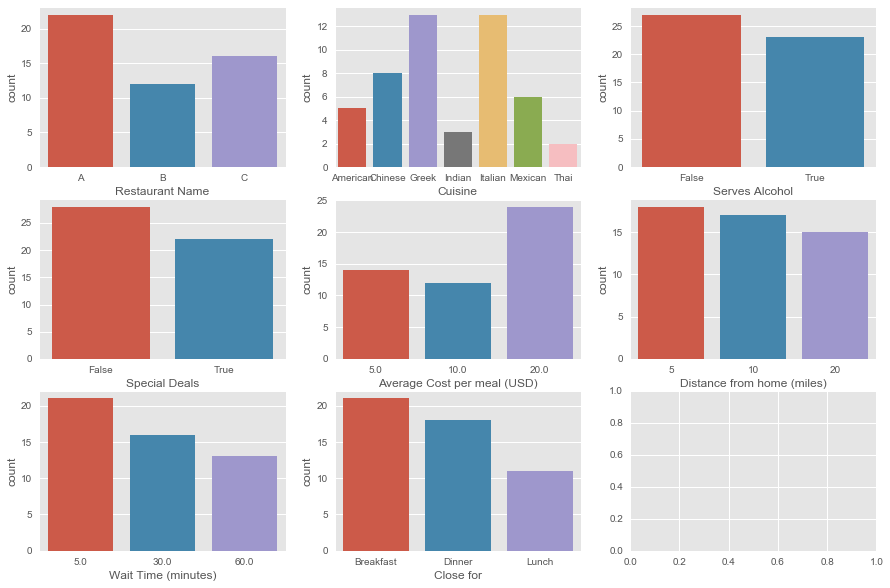

In [11]:
n_rows = ceil(sqrt(len(df.columns)))
fig, axarr = plt.subplots(n_rows, n_rows)
for idx, col in enumerate(df.columns):
    i, j = idx//n_rows, idx%n_rows
    _ = sns.countplot(df[col], ax=axarr[i][j])

------------------------------

Since we want to look at the data from all angles of the **8** features that we have, let's try to plot something similar to above plot for each feature at hand  

Observations:
- Most of our users (in this sample) live closer to **Restaurant B**
- *Thai* at Restaurant B and *Indian* at Restaurant C are not a popular choice (or might not be available)
- Wait time at restaurant that do serve alcohol seems to be higher
- Users tend to visit a restaurant that is far even if doesn't offer Special Deals (or visit something closer if it does offer Special Deals)
- **Greek** seems to be a famous choice (and people are spending more for Greek food as well)

These observations are pretty coarse, as we are looking at counts and not actual values  
But they are good enough to give us a headstart. Now let's look at the data closer and see if there's proof to validate above observations.

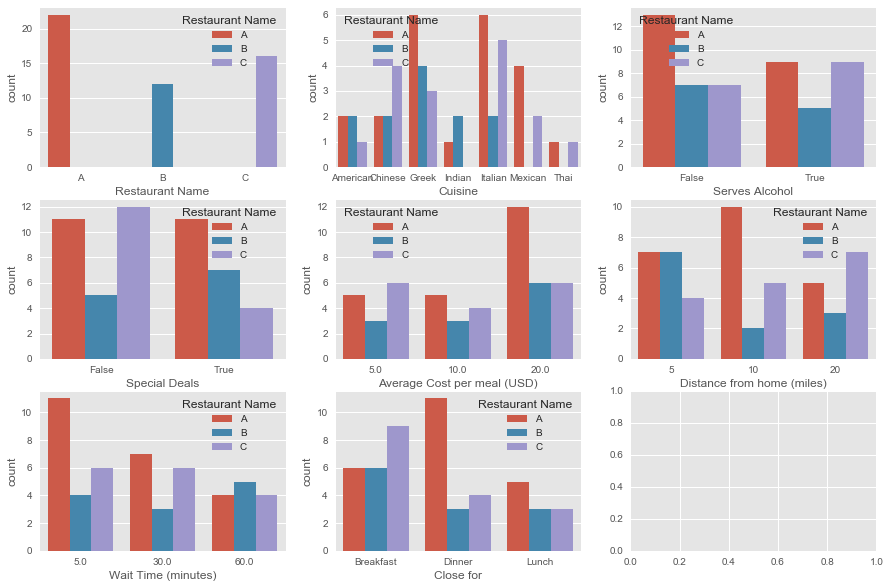

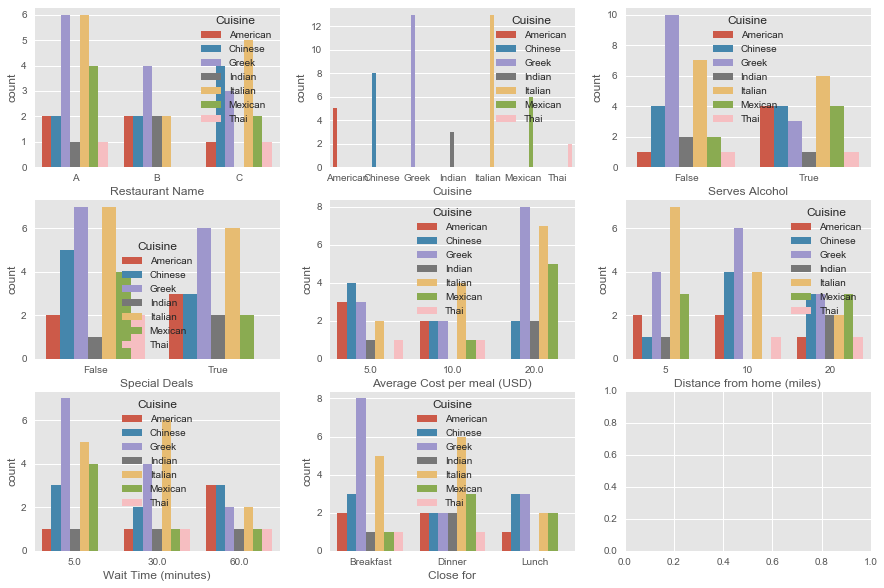

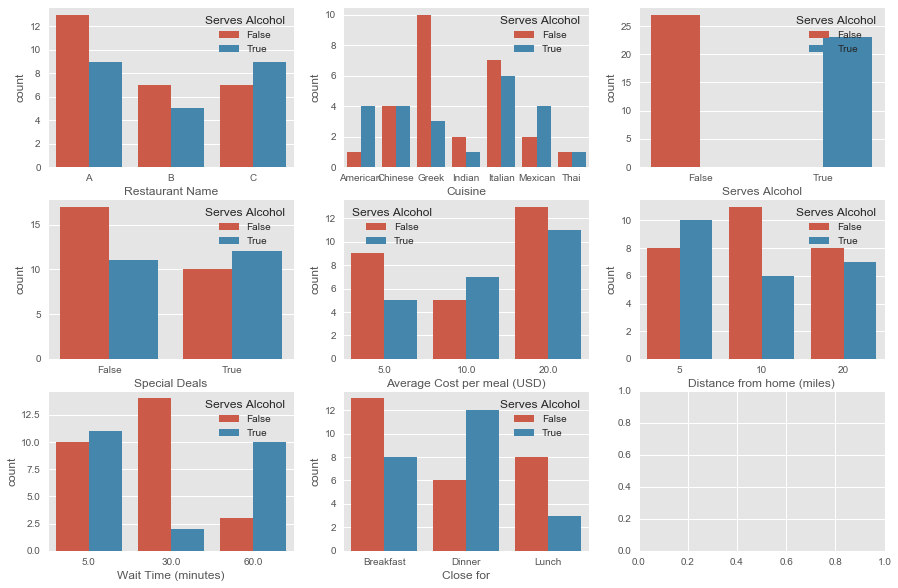

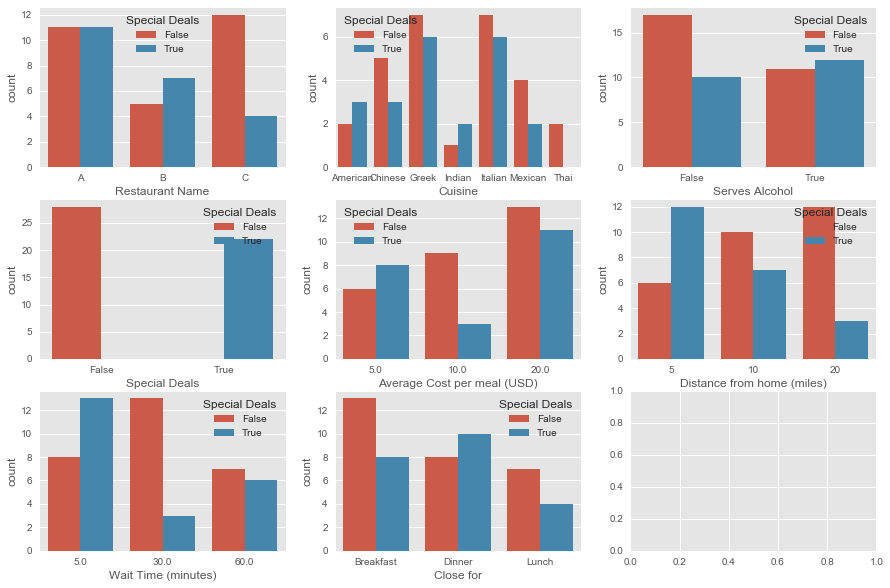

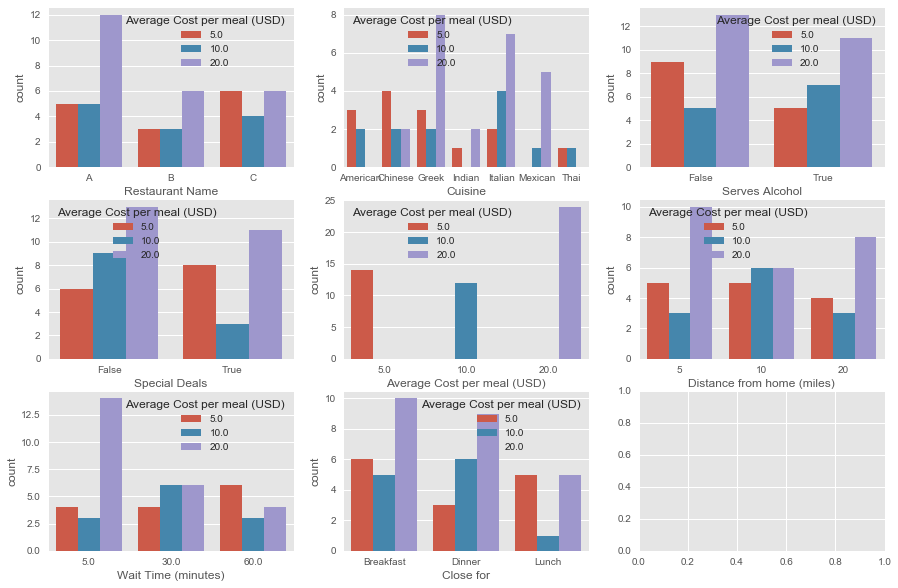

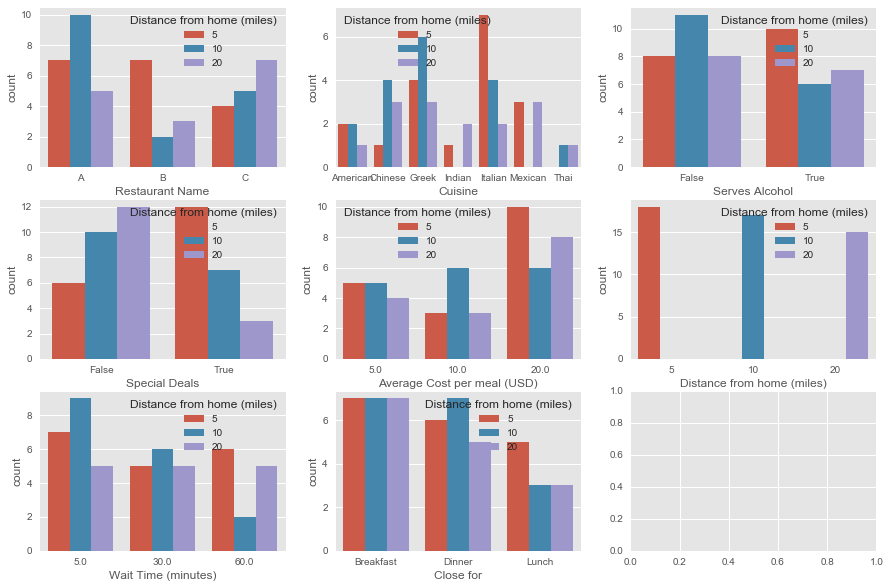

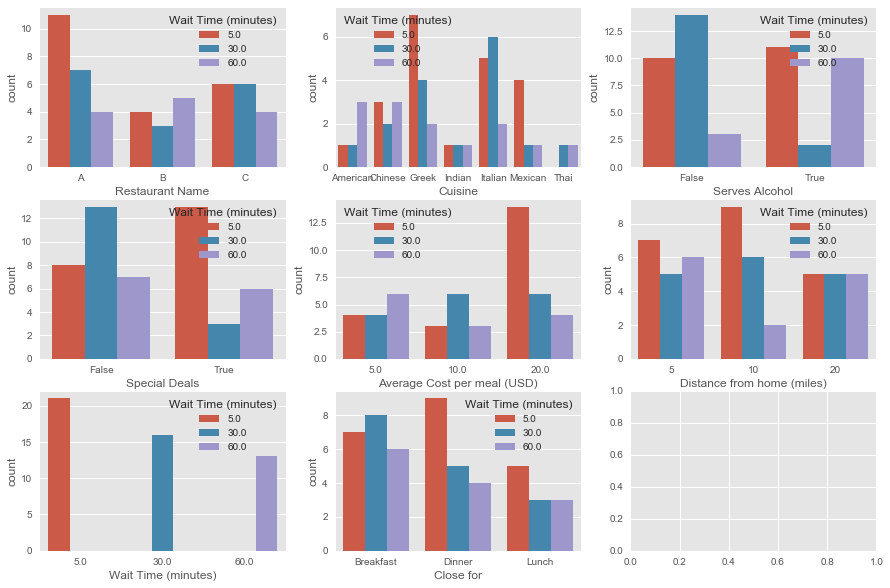

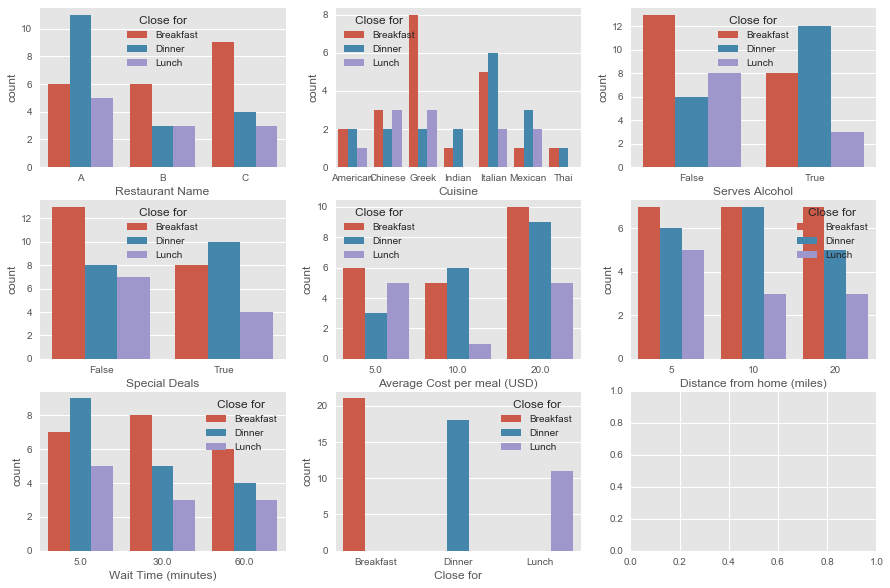

In [12]:
n_rows = ceil(sqrt(len(df.columns)))
for hue_col in df.columns:
    fig, axarr = plt.subplots(n_rows, n_rows)
    for idx, col in enumerate(df.columns):
        i, j = idx//n_rows, idx%n_rows
        _ = sns.countplot(df[col], ax=axarr[i][j], hue=df[hue_col])

------------------------------

Let's try to group by Cuisine and see what trends we can observe

Observations:
- It looks like most of the **American** restaurants tend to serve alcohol  
- Wait time is lowest for Mexican cuisine and highest for American cuisine (most likely due to differences in cooking style - grilling and deep frying take longer)
- Average mexican meal seems to be the most expensive, while American meal seems to be budget friendly

In [13]:
df_by_cuisine = df.groupby("Cuisine").mean()
df_by_cuisine['Count'] = df.groupby("Cuisine").count()["Serves Alcohol"]

In [14]:
df_by_cuisine

,Serves Alcohol,Special Deals,Average Cost per meal (USD),Distance from home (miles),Wait Time (minutes),Count
Cuisine,,,,,,
American,0.800000,0.600000,7.000000,10.000000,43.000000,5
Chinese,0.500000,0.375000,10.000000,13.125000,31.875000,8
Greek,0.230769,0.461538,15.000000,10.769231,21.153846,13
Indian,0.333333,0.666667,15.000000,15.000000,31.666667,3
Italian,0.461538,0.461538,14.615385,8.846154,25.000000,13
Mexican,0.666667,0.333333,18.333333,12.500000,18.333333,6
Thai,0.500000,0.000000,7.500000,15.000000,45.000000,2


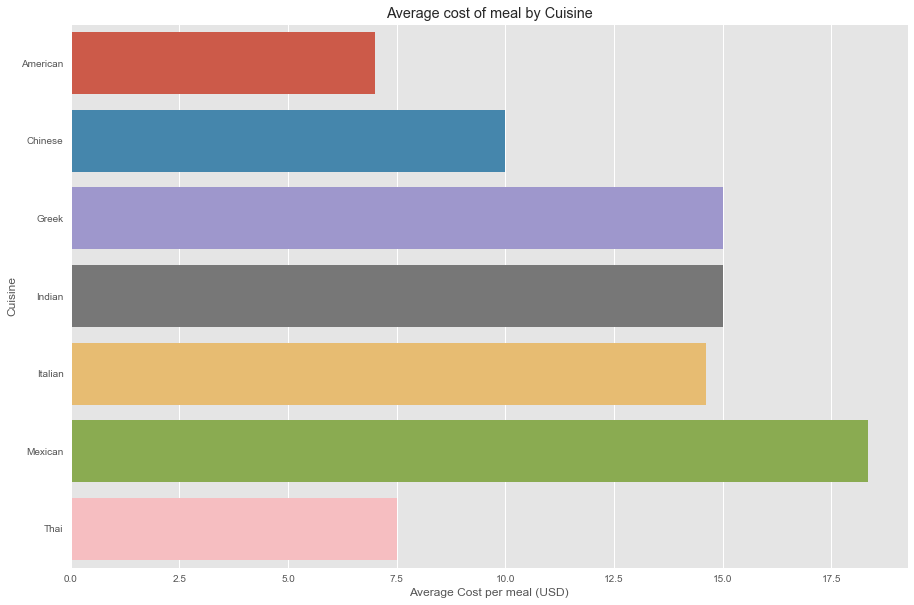

In [15]:
df_by_cuisine = df_by_cuisine.reset_index()
_ = sns.barplot(x="Average Cost per meal (USD)", y="Cuisine", data=df_by_cuisine).set_title("Average cost of meal by Cuisine")

------------------------------

Looking at Cuisines and Restaurants together, we validate our earlier observations:
- **Restaurant A** is the most visited restaurant
- with **Greek** and **Italian** being the popular choices
- Restaurant C also seems to be a famous choice for Italian cuisine

In [16]:
df_temp = df[["Restaurant Name", "Cuisine"]].groupby(["Restaurant Name", "Cuisine"]).size().to_frame(name="Visits").reset_index()
df_by_restaurant_and_cuisine = df_temp.pivot(index="Restaurant Name", columns="Cuisine", values="Visits").fillna(0.0)

In [17]:
df_by_restaurant_and_cuisine

Cuisine,American,Chinese,Greek,Indian,Italian,Mexican,Thai
Restaurant Name,,,,,,,
A,2.0,2.0,6.0,1.0,6.0,4.0,1.0
B,2.0,2.0,4.0,2.0,2.0,0.0,0.0
C,1.0,4.0,3.0,0.0,5.0,2.0,1.0


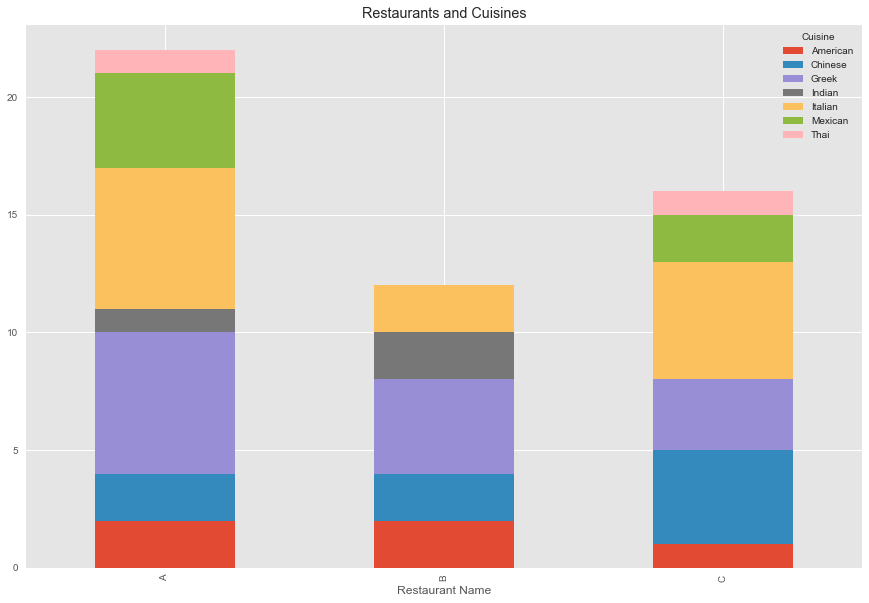

In [18]:
_ = df_by_restaurant_and_cuisine.plot(kind="bar", stacked=True).set_title("Restaurants and Cuisines")

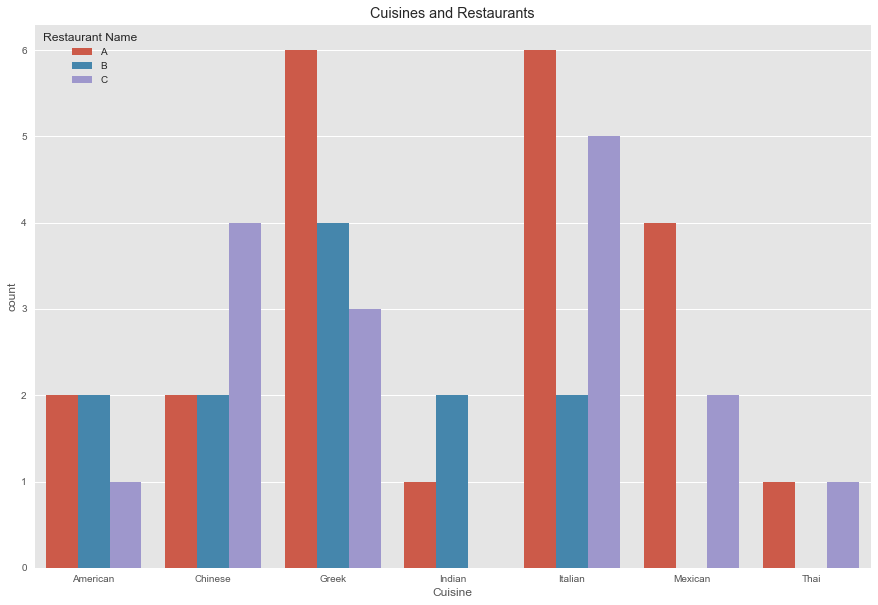

In [19]:
_ = sns.countplot(x="Cuisine", data=df, hue="Restaurant Name").set_title("Cuisines and Restaurants")

------------------------------

If we plot the average meal cost by cuisine and restaurant, we can again validate our earlier observations:
- **Greek** food is expensive, **Italian** is a close second
- We have less data for Indian and Thai cuisines
- **Restaurant B** seems to offer a wider range in **Greek** as compared to **Italian** (But if we look at no. of visits, this observation is not true)

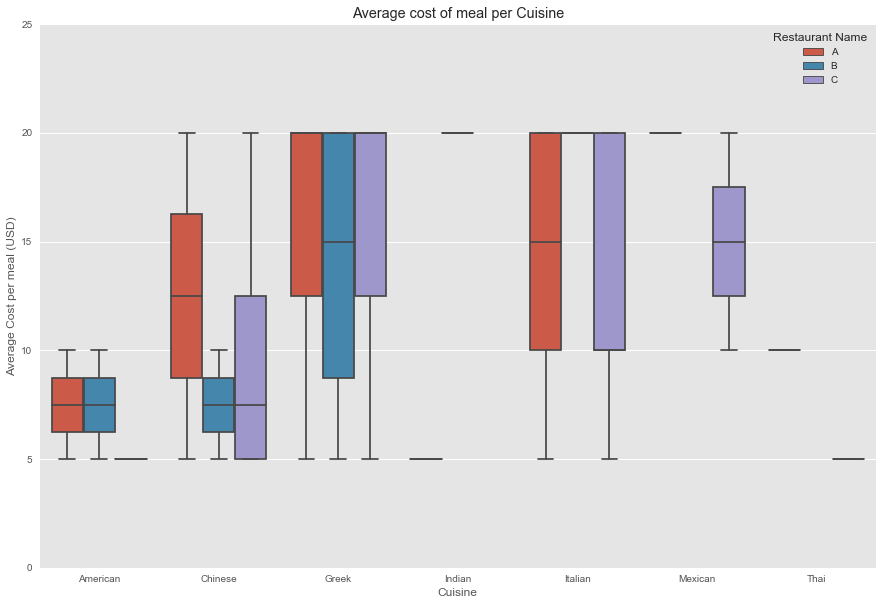

In [20]:
ax = sns.boxplot(x="Cuisine", y="Average Cost per meal (USD)", data=df, hue="Restaurant Name")
_ = ax.set(ylim=(0, 25))
_ = ax.set_title("Average cost of meal per Cuisine")

------------------------------

Let's take a look at the '*Special Deals*' attribute.  
If we look at average cost by restaurant, and factor in if it had 'Special Deals',  
we see that the cost decreases if special deals were available (which is logical).  

Now, when we transform our data to see the percentage difference in average price if special deal was available,  
we observe that **Restaurant C** offers the best deals! (as it shows the most percentage drop - approx 20% - in average price if Special Deals are available).

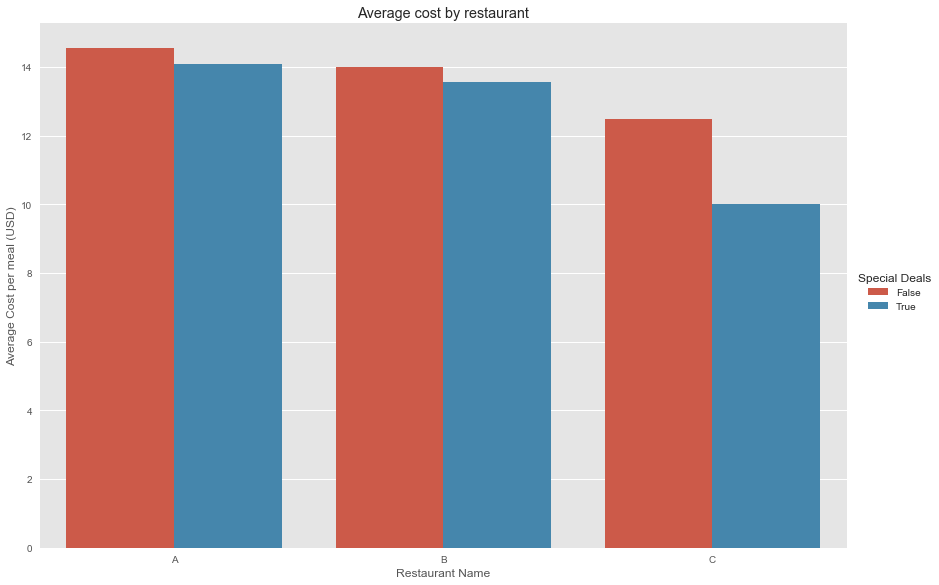

In [21]:
avg_cost_with_deals = df.groupby(["Restaurant Name", "Special Deals"], as_index=False)\
                        .mean()[["Restaurant Name", "Special Deals", "Average Cost per meal (USD)"]]
_ = sns.factorplot(x="Restaurant Name", y="Average Cost per meal (USD)", hue="Special Deals", kind="bar",
                   data=avg_cost_with_deals, size=8, aspect=1.5)
_ = plt.title("Average cost by restaurant")

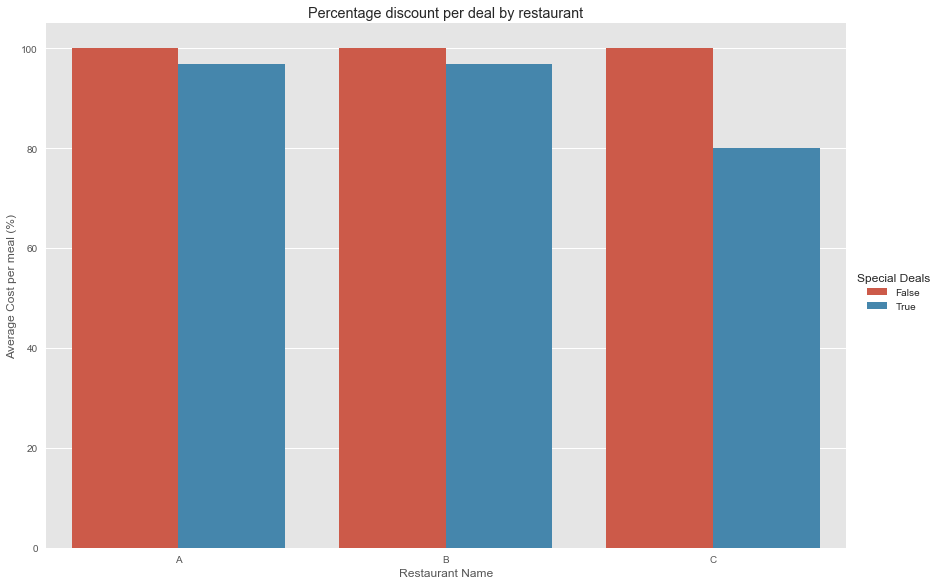

In [22]:
df_temp = df.groupby(["Restaurant Name", "Special Deals"], as_index=False)\
            .mean()[["Restaurant Name", "Special Deals", "Average Cost per meal (USD)"]]
avg_cost_with_deals = \
    df_temp.pivot(
        index="Special Deals", columns="Restaurant Name", values="Average Cost per meal (USD)"
    ).pct_change().fillna(0.0).transform(lambda t: 100 + t*100).unstack().reset_index()\
    .rename(columns={0: "Average Cost per meal (USD)"})
_ = sns.factorplot(x="Restaurant Name", y="Average Cost per meal (USD)", hue="Special Deals", kind="bar",
                   data=avg_cost_with_deals, size=8, aspect=1.5)
_ = plt.ylabel("Average Cost per meal (%)")
_ = plt.title("Percentage discount per deal by restaurant")

------------------------------

Let's take closer look at '*Wait Times*'.  
By looking at following point plot, it seems like the wait time is lower if the average cost of the food is higher.  
This might identify as "Expensive restaurants : Less crowd : Quicker service" or "Famous expensive food items : Readily available : Quicker service". We'll need to look at more data to know more.  

If we dig deeper and plot it by restaurants, we observe:
- If one is willing to spend an average of 20 USD per meal, Restaurant B seems to the one with lowest wait times
- Budget food (Average aroud 5 USD per meal) may take anywhere between 5-60 mins at Restaurant A

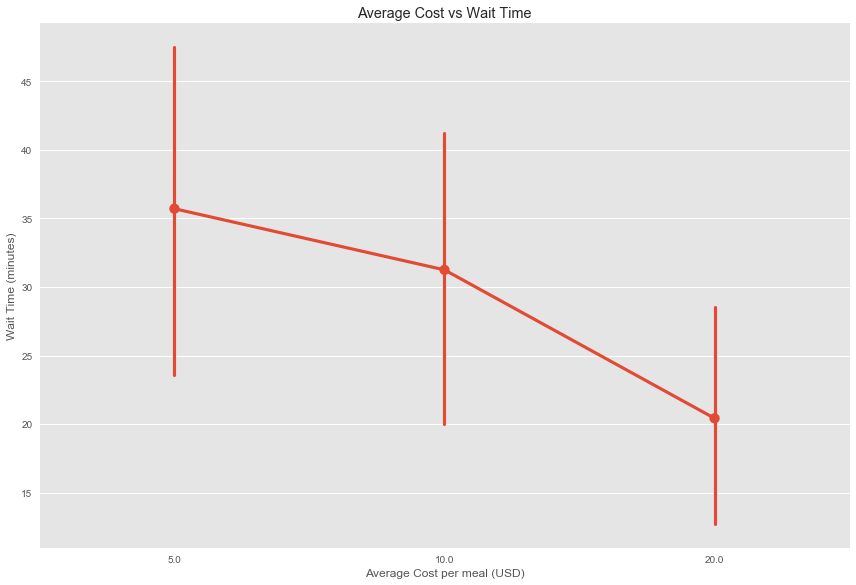

In [23]:
_ = sns.factorplot(x="Average Cost per meal (USD)", y="Wait Time (minutes)", data=df, kind="point", size=8, aspect=1.5)
_ = plt.title("Average Cost vs Wait Time")

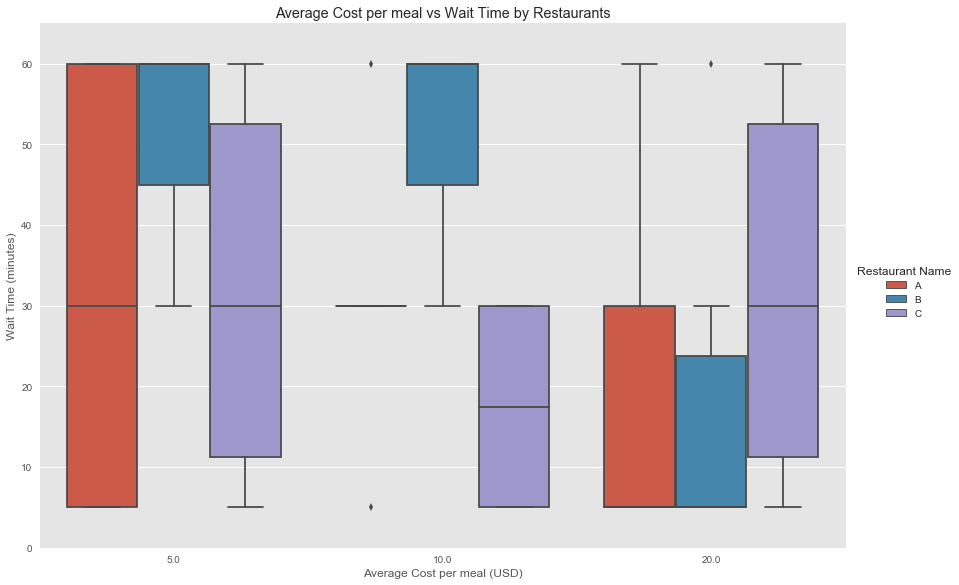

In [24]:
ax = sns.factorplot(x="Average Cost per meal (USD)", y="Wait Time (minutes)", 
                    data=df, hue="Restaurant Name", kind="box", size=8, aspect=1.5)
_ = ax.set(ylim=(0, 65))
_ = plt.title("Average Cost per meal vs Wait Time by Restaurants")

------------------------------

The data contains an ambiguous column titled 'Close for '. Going by the general assumption that it means that restaurant might not offer that cuisine during the mentioned time.  

Based on that assumption, let's take a loot at restaurants that are '*open*' for '*Dinner*'.  

The average wait for dinner seems to be higher for *Greek* food if the restaurant also serves alcohol.  
In general, if the restaurant offeres Alcohol, the average wait times are higher, except for Chinese and surprisingly Italian.  

If we look the violin plot, we'd observe that people tend to spend more if the restaurant is closer, but also spend more if a farther restaurant serves alcohol.  
Given more data points, and maybe a continuous distribution, this plot would serve more for observation.

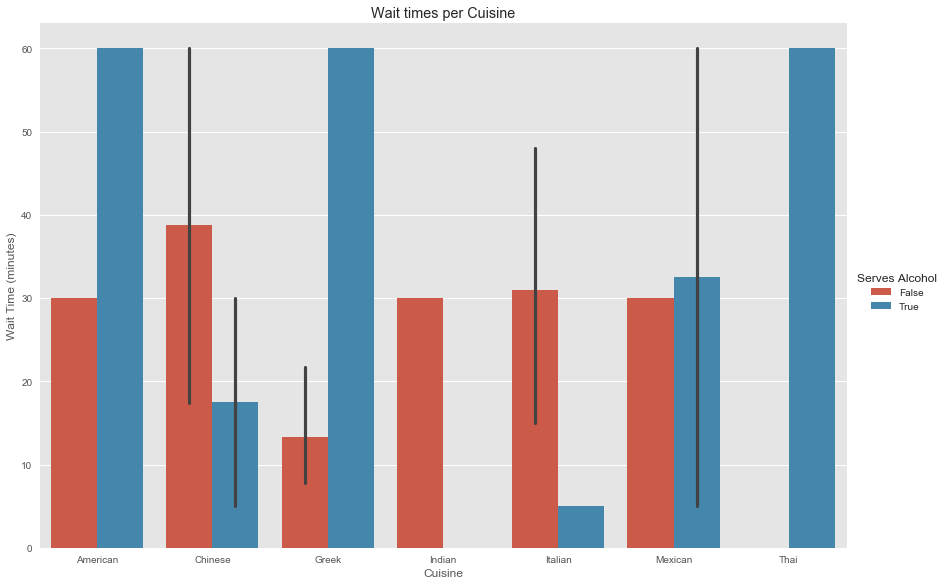

In [25]:
df_open_dinner = df[df["Close for"] != "Dinner"]
_ = sns.factorplot(x="Cuisine", y="Wait Time (minutes)", hue="Serves Alcohol", data=df_open_dinner, 
                   kind="bar", size=8, aspect=1.5)
_ = plt.title("Wait times per Cuisine")

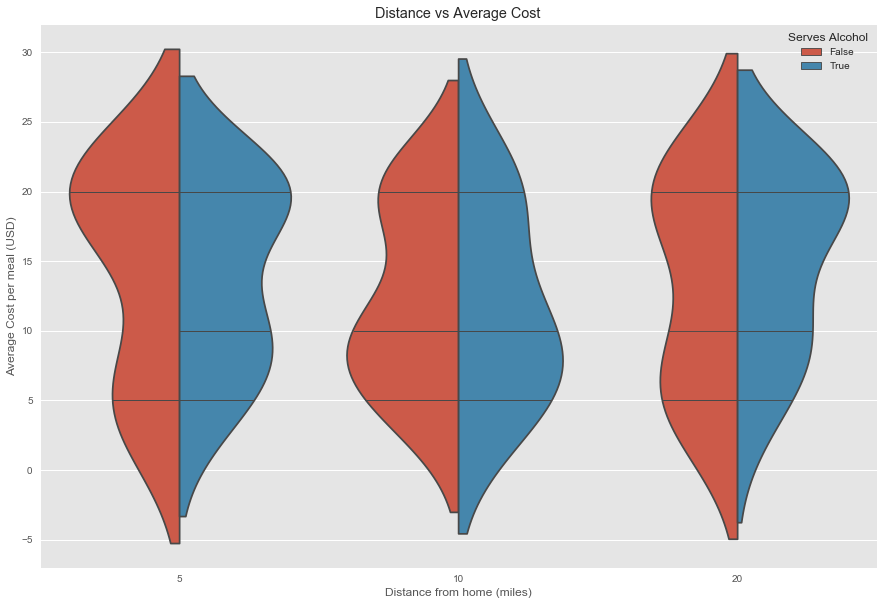

In [26]:
_ = sns.violinplot(x="Distance from home (miles)", y="Average Cost per meal (USD)",
                   data=df, inner="stick", split=True, hue="Serves Alcohol")
_ = plt.title("Distance vs Average Cost")

-----------------------------------------------------------

#### Conclusion
We've taken a deeper look at each of the **8** factors provided to us.  
By looking at various plots above gives us some basic idea about trends in this small sample.  
Given more data points, we can definitely follow up on these trends and reach solid conclusions.  

#### References
- http://pythonplot.com/
- https://seaborn.pydata.org/tutorial/categorical.html
- https://medium.com/@mjspeck/presenting-code-using-jupyter-notebook-slides-a8a3c3b59d67

## Thank You